In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import datetime as dt
import pprint as pp
import pandas as pd
from IPython.display import display

from sklearn.preprocessing import StandardScaler


In [32]:
df = pd.read_pickle('../data/player_game_table.pkl')
df2 = pd.read_pickle('./player_vs_table_3.pkl')

features = ['ast','blk','dreb','fg3a','fg3m','fga','fgm','fta','ftm','min','oreb', 'pts','reb','stl','to',
            'fantasy_points']
matchup_features = ['fgm','fga','fg3m','fg3a','ftm','fta','oreb','dreb','reb','ast','tov','stl','blk','pts',"fantasy_points"]

In [33]:
def create_input_features(pid, n, df, feats):
    rows = df.loc[ (df['player_id'] == pid) & (df['season'] == "2017-2018")]
    rows = rows.sort_values("game_date")

    X = np.zeros(( (len(rows) - (n), (len(feats)*n)+len(matchup_features))))
    y= np.zeros((len(rows) - (n)))

    for i in range(n, (len(rows) - 1)):
        last_n = rows.iloc[(i - n) : i]
        #X[(i - n),0] = pid
        fp_opp = []
        min_opp = []
        
        for a,feat in enumerate(feats):
            start_idx = a*n
            end_idx = start_idx + n
            X[(i - n),start_idx:end_idx] = last_n[feat].tolist()
        for b,mufeat in enumerate(matchup_features):
            #Calculate matchup statistics
            current_game = df.iloc[i].game_id
            pids = df.loc[df.game_id == current_game].player_id
            for pid in pids:
                x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2016-17')]
                if len(x)>0:
                    fp_opp.append(x[mufeat].values[0])
                    min_opp.append(x["min"].values[0])
                    
            feature_average = np.ma.average(fp_opp,weights = min_opp)
            X[(i-n), len(feats)*n+b] = feature_average
            
        y[i-n] = rows.iloc[i]["fantasy_points"]
        
    return X, y

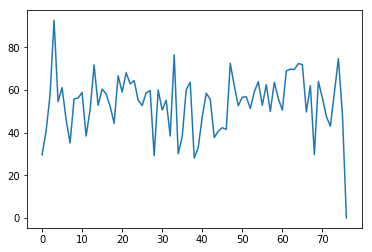

In [34]:
X, y = create_input_features('2544', 5, df, features)
lebron_dict = {}
lebron_dict["X"] = X
lebron_dict["y"] = y

with open('lebron_2018.pkl', 'wb') as fp:
    pickle.dump(lebron_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)


plt.plot([i for i in range(len(y))],y)
plt.show()

In [35]:
scaler = StandardScaler()

X = scaler.fit_transform(X,y)
X = X[:-1]
y = y[:-1]
print(np.shape(X))

(76, 95)


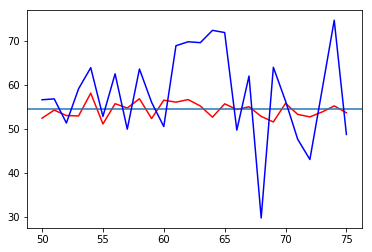

-0.028677857368464288


In [51]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=20, random_state=0,n_estimators=1000,criterion = 'mae',n_jobs =8,max_features=90)
train_split = 2/3
train_n = int(len(y)*train_split)
regr.fit(X[:train_n],y[:train_n])

plt.plot(list(range(train_n,len(y))),regr.predict(X[train_n:]),'r')
plt.axhline(y = np.average(y))
plt.plot(list(range(train_n,len(y))),y[train_n:],'b')
plt.show()
print(regr.score(X[train_n:],y[train_n:]))